In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Informer-Like

[FeedForwardBlock] Using Mixture-of-Experts
[MultiAttention] Initialized with attention type: sliding_window, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: prob_sparse, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[MultiAttention] Initialized with attention type: prob_sparse, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}


Training: 100%|██████████| 50/50 [00:06<00:00,  7.68epoch/s, epoch=50, train_loss=0.0929, lr=1.00e-03]


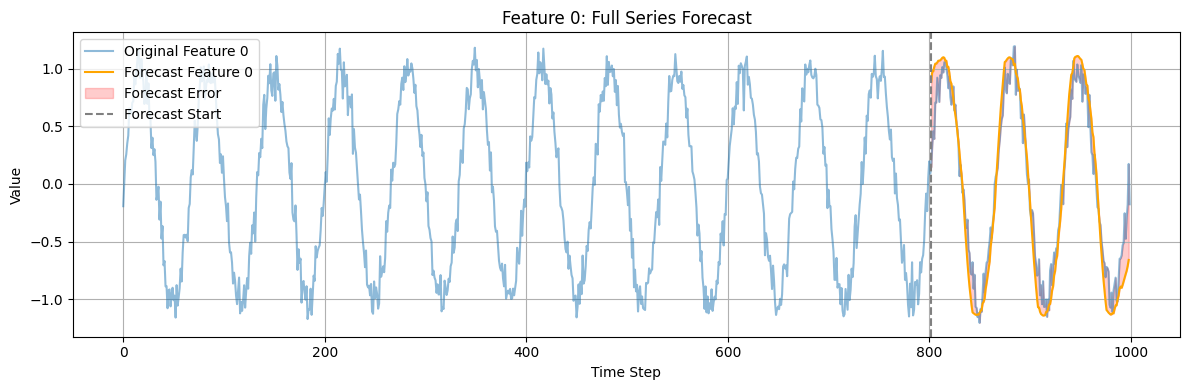

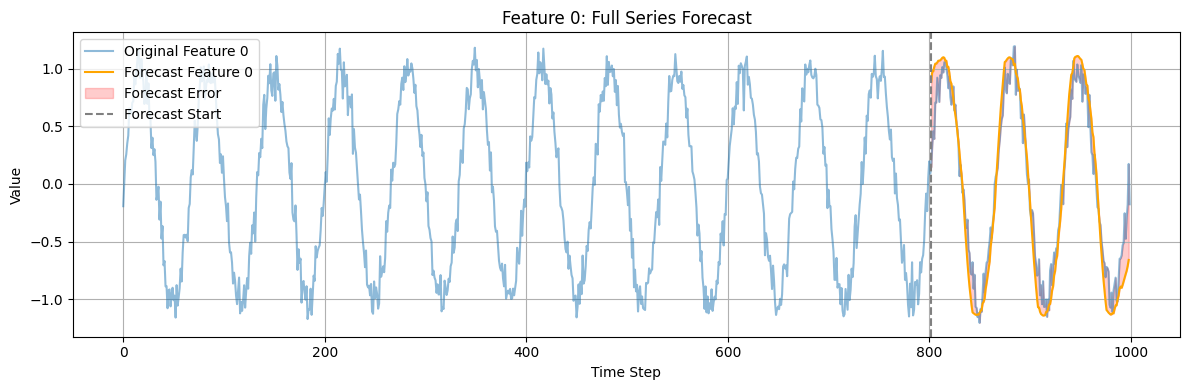

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer


# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

from foreblocks.tf.embeddings import RoPEPositionalEncoding

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
    att_type="sliding_window",  # Use probabilistic sparse attention
    use_moe=True,  # Use Mixture of Experts
    use_adaptive_ln="rms",
    pos_encoder=RoPEPositionalEncoding(
        d_model=model_params.get("input_processor_output_size", 1),
        max_len=model_params.get("seq_len", 50),
    ),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
    informer_like=True,  # Use Informer-like architecture,
    att_type="prob_sparse",  # Use probabilistic sparse attention
    use_adaptive_ln="rms",
    #use_moe=True,  # Use Mixture of Experts
)

total_epochs = 50  # Total number of epochs for training
def scheduled_sampling_fn(epoch):
    # Use a linear decay from 1.0 to 0.0 over the epochs
    tf_ratio = max(0.0, 0.95 - (epoch / total_epochs))

    return tf_ratio

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="informer-like",  # Use Informer-like architecture
    scheduled_sampling_fn=scheduled_sampling_fn,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]
# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader, epochs=total_epochs)
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)




# LSTM

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



[Attention] Method: dot, Backend: xformers
[Attention] xformers version: 0.0.30
[Attention] FlashAttention version: 2.7.4.post1


Training:   0%|          | 0/100 [00:00<?, ?epoch/s, epoch=2, train_loss=0.3535, lr=1.00e-03]

Training:  46%|████▌     | 46/100 [00:01<00:01, 28.72epoch/s, epoch=46, train_loss=0.0095, lr=1.00e-03]


KeyboardInterrupt: 

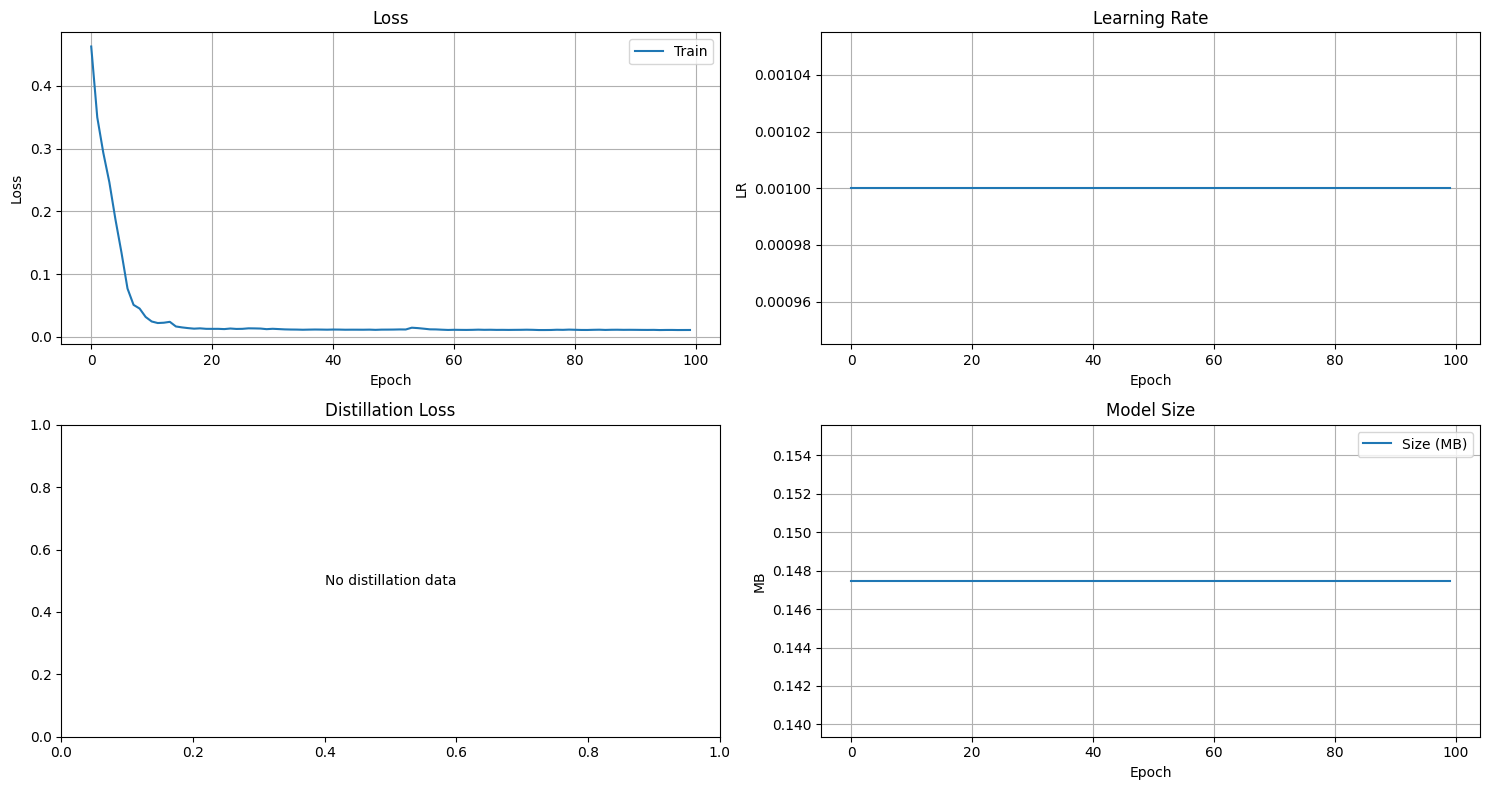

In [ ]:
trainer.plot_learning_curves()

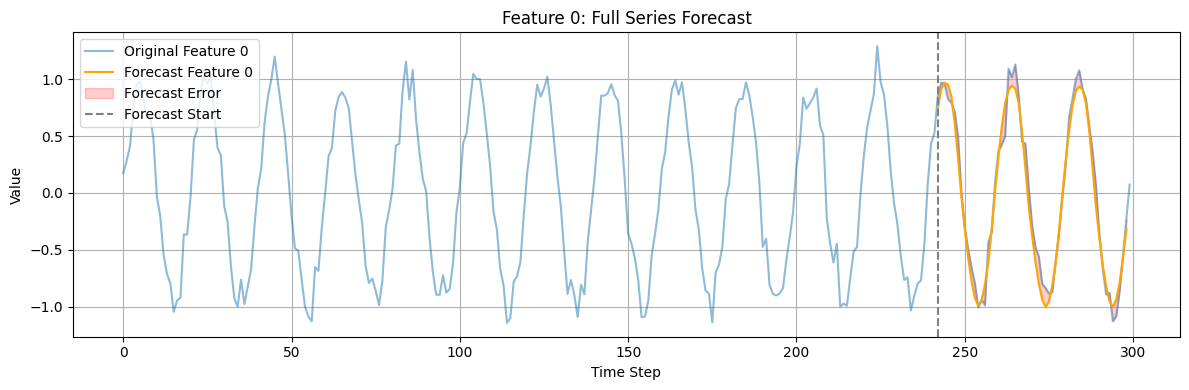

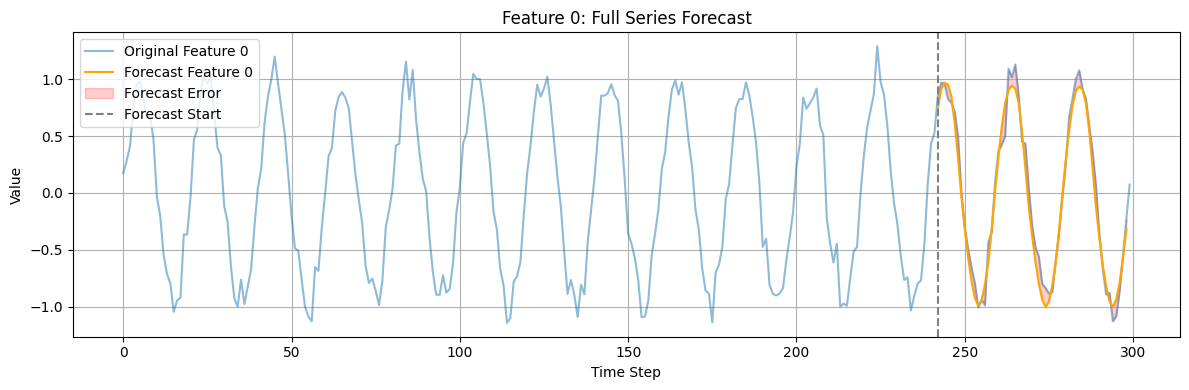

In [ ]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)


# Transformer

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="transformer",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())
#trainer.set_config('num_epochs', 200)
# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)




[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[MultiAttention] Initialized with attention type: standard, available backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}


Training:  34%|███▍      | 34/100 [00:05<00:10,  6.04epoch/s, epoch=34, train_loss=0.0621, lr=1.00e-03]


KeyboardInterrupt: 

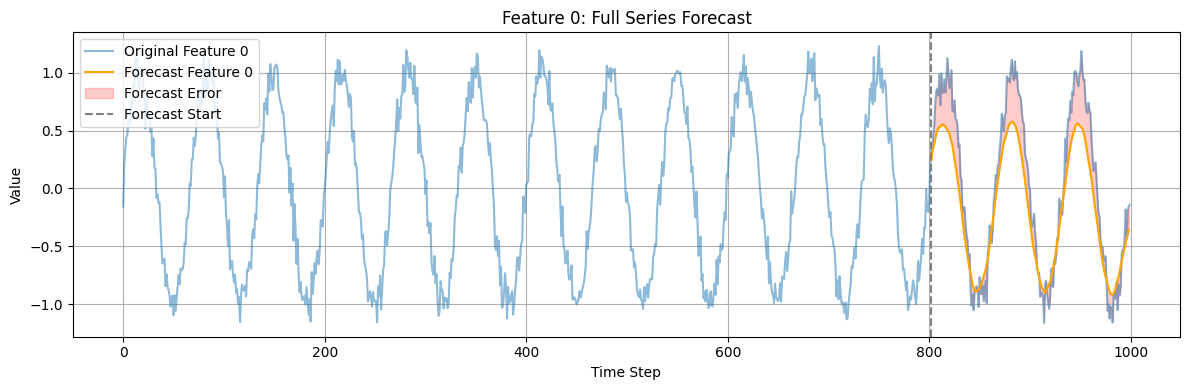

In [ ]:
fig = trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)